# Toy example

In [1]:
import bhad 
import utils as util
import numpy as np
import matplotlib.pyplot as plt

### Draw from a two-component multivariate Student-t mixture distribution

Note: Anomaly class corresponds to the minority mixture component

In [2]:

seed = 42  
outlier_prob_true = .01         # probab. for outlier ; should be consistent with contamination rate in your model
k = 30                          # feature dimension 
N = 5*10**4                     # sample size

# Specify first and second moments for each component  
bvt = util.mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,.5), 
                            'Sigma1' : np.eye(k)*.4, 'Sigma2' : np.eye(k)*.1, 
                            'nu1': 3.*k, 'nu2': 3.*k}, seed = seed, gaussian = False)

# Get latent draws and observations:
#------------------------------------
y_true, dataset = bvt.draw(n_samples = N, k = k, p = outlier_prob_true)

print(dataset.shape)

(50000, 30)


In [3]:
y_true.mean()    # probab. latent class 1 (=anomaly)

0.01024

### Visualize the data:

In [7]:
#bvt.show2D(alpha = .45, edgecolor='k', save_plot = False)
#bvt.show3D(alpha = .45, edgecolor='k', save_plot = False)    # plot the first three dimensions

Reduce dimension for visualization only:

In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(dataset)

X_reduce = TruncatedSVD(n_components=3).fit_transform(X)

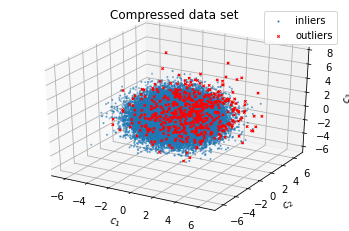

In [5]:
# Plot all the ground truth points together with the predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("Compressed data set")
ax.set_xlabel(r'$c_{1}$') ; ax.set_ylabel(r'$c_{2}$') ;ax.set_zlabel(r'$c_{3}$')

# Plot the compressed inliers data points
ax.scatter(X_reduce[y_true == 0, 0], X_reduce[y_true == 0, 1], zs=X_reduce[y_true == 0, 2], s=4, lw=0, label = "inliers")

# outliers
ax.scatter(X_reduce[y_true == 1, 0], X_reduce[y_true == 1, 1], zs=X_reduce[y_true == 1, 2], 
           lw=1, s=6, marker="x", c="red", alpha=1, label = "outliers")
ax.legend()
plt.show();

### Model training

Discretize continuous features + train BHAD:

In [6]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    # if nbins = None, this will automatically select the optimal bin numbers 
    # based on the MAP estimate (but will make computation slower!)
    ('discrete' , util.discretize(nbins = 30)),      # step only needed if continous features are present
    ('model', bhad.BHAD(contamination = 0.01))
])


In [7]:
y_pred = pipe.fit_predict(dataset)     

Used 30 numeric feature(s).
Binned continous features into 30 bins.

Construct Bayesian Histogram-based Anomaly Detector (BHAD).
One-hot encoding of categorical features
Matrix dimension after one-hot encoding: (5000, 738)
BHAD completed.


In [8]:
scores = pipe.decision_function(dataset)
#scores = pipe.score_samples(dataset)

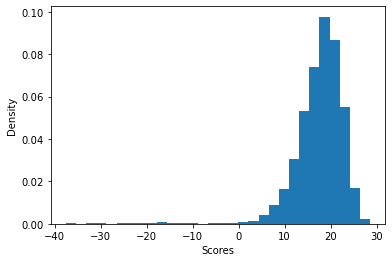

In [9]:
plt.hist(scores, density=True, bins=30)  # density=False would make counts
plt.ylabel('Density')
plt.xlabel('Scores');

In [10]:
from sklearn.metrics import classification_report

# Make comparable to BHAD encoding
y_true[y_true == 1] = -1
y_true[y_true == 0] = 1

print(classification_report(y_true, y_pred, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       0.90      0.94      0.92        48
     Outlier       1.00      1.00      1.00      4952

    accuracy                           1.00      5000
   macro avg       0.95      0.97      0.96      5000
weighted avg       1.00      1.00      1.00      5000



In [11]:
np.unique(y_true, return_counts=True)

(array([-1,  1]), array([  48, 4952], dtype=int64))

In [12]:
np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([  50, 4950], dtype=int64))